In [38]:
import re
from collections import Counter
import string
import random
import math
import re
import nltk
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict

In [39]:
dataset = pd.read_csv('rt_reviews.csv',encoding = "latin-1")

In [40]:
# Convert the 'Review' column to lowercase
reviews = dataset['Review'].str.lower()

# Remove any special symbols or punctuation from the reviews by replacing them with a white space
reviews = reviews.str.replace('[^\w\s]', ' ')



# Update the 'Review' column in the dataset with the cleaned reviews
dataset['Review'] = reviews

# Print the updated dataset
print(dataset)


/var/folders/35/v0xvkgj172q11bynlvhstr2r0000gn/T/ipykernel_12376/3367611730.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  reviews = reviews.str.replace('[^\w\s]', ' ')


       Freshness                                             Review
0          fresh   manakamana doesn t answer any questions  yet ...
1          fresh   wilfully offensive and powered by a chest thu...
2         rotten   it would be difficult to imagine material mor...
3         rotten   despite the gusto its star brings to the role...
4         rotten   if there was a good idea at the core of this ...
...          ...                                                ...
479995    rotten   zemeckis seems unable to admit that the motio...
479996     fresh   movies like the kids are all right    beautif...
479997    rotten   film savvy audiences soon will catch onto win...
479998     fresh                        an odd yet enjoyable film  
479999     fresh   no other animation studio  even our beloved p...

[480000 rows x 2 columns]


In [41]:
dataset['Review']

0          manakamana doesn t answer any questions  yet ...
1          wilfully offensive and powered by a chest thu...
2          it would be difficult to imagine material mor...
3          despite the gusto its star brings to the role...
4          if there was a good idea at the core of this ...
                                ...                        
479995     zemeckis seems unable to admit that the motio...
479996     movies like the kids are all right    beautif...
479997     film savvy audiences soon will catch onto win...
479998                          an odd yet enjoyable film  
479999     no other animation studio  even our beloved p...
Name: Review, Length: 480000, dtype: object

In [42]:
# Set the proportions for the train, dev, and test datasets
train_size = 0.8
dev_size = 0.1
test_size = 0.1

# Split the dataset into the train and remaining portions
dataset_train = dataset[0:train_index]
dataset_rem = dataset[train_index:]
dataset_rem # The remaining portion of the dataset after the train portion

# Split the remaining portion into the dev and test portions
dev_index = int(len(dataset)*dev_size)
dataset_dev = dataset[train_index:train_index+dev_index]
dataset_test = dataset[train_index+dev_index:]


# Print the lengths of the resulting datasets
print(f"Train dataset length: {len(dataset_train)}")
print(f"Dev dataset length: {len(dataset_dev)}")
print(f"Test dataset length: {len(dataset_test)}")




Train dataset length: 384000
Dev dataset length: 48000
Test dataset length: 48000


In [43]:
# Print information about the train dataset
print("********** TRAINING DATASET *************")
print(dataset_train.info())  # Print the column data types, non-null values, and memory usage
print(dataset_train.shape)  # Print the dimensions of the dataset (number of rows and columns)

# Print information about the test dataset
print("\n********** TESTING DATASET *************")
print(dataset_test.info())
print(dataset_test.shape)

# Print information about the dev dataset
print("\n********** DEVELOPMENT DATASET *************")
print(dataset_dev.info())
print(dataset_dev.shape)


********** TRAINING DATASET *************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384000 entries, 0 to 383999
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Freshness  384000 non-null  object
 1   Review     384000 non-null  object
dtypes: object(2)
memory usage: 5.9+ MB
None
(384000, 2)

********** TESTING DATASET *************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 432000 to 479999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Freshness  48000 non-null  object
 1   Review     48000 non-null  object
dtypes: object(2)
memory usage: 750.1+ KB
None
(48000, 2)

********** DEVELOPMENT DATASET *************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 384000 to 431999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Freshness  48000 n

In [44]:
# Split the train, dev, and test datasets into feature and target data
dataset_train_X = dataset_train['Review']
dataset_dev_X = dataset_dev['Review']
dataset_test_X = dataset_test['Review']

dataset_train_y = dataset_train['Freshness']
dataset_dev_y = dataset_dev['Freshness']
dataset_test_y = dataset_test['Freshness']

# Print the count of each target class in the training dataset
unique_training_types = list(dataset_train_y.unique())
dict_types = {}
for class_type in unique_training_types:
  dict_types[class_type] = sum(dataset_train_y == class_type)

for key_type, count in dict_types.items():
  print(key_type + ": " + str(count))


fresh: 192306
rotten: 191694


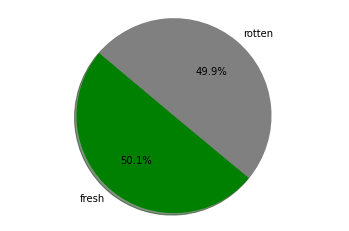

In [45]:
import numpy as np 
import matplotlib.pyplot as plt 
  
# Get the count of each target class from the dict_types dictionary
labels = dict_types.keys()
count = dict_types.values()

# Plot the data as a pie chart
plt.pie(count, labels=labels, 
        autopct='%1.1f%%', shadow=True, startangle=140, colors=['Green', 'grey'])
plt.axis('equal')
plt.show()


In [46]:
# Define a function to calculate the prior probability of each class type
def calculate_prior_probability(): 
  # Initialize an empty dictionary to store the prior probability of each class type
  sentence_type_prior_probability = dict()
  
  # Calculate the total number of sentences in the training dataset
  total_sentence_count = dataset_train_y.size
  
  # Calculate the prior probability of each class type and store it in the dictionary
  for key_type, value_count in dict_types.items():
    sentence_type_prior_probability[key_type] = value_count / total_sentence_count;
  
  # Return the dictionary of prior probabilities
  return sentence_type_prior_probability

# Print the prior probability of each class type
for key_type, probability in calculate_prior_probability().items():
  print(key_type + ": " + str(probability))


fresh: 0.500796875
rotten: 0.499203125


In [47]:
import re
import nltk
from nltk.corpus import stopwords

# Download the 'stopwords' corpus from the NLTK library
nltk.download('stopwords')

# Create a set of English stopwords to be removed from the text
stop_words_set = set(stopwords.words('english'))

# Define a function that builds a vocabulary list of words from a list of sentences
def build_vocabulary(sentences, remove_stop_words=False):
  
  # Initialize an empty vocabulary list and a dictionary to store word counts
  vocabulary_list = []
  dictionary_word_count = {}

  # Loop through each sentence in the input list
  for sentence in sentences:
    
    # Split the sentence into individual words
    words_in_sentence = str(sentence).split(' ')
    
    # Loop through each word in the sentence
    for each_word in words_in_sentence:
      
      # Remove any digits from the word
      each_word = re.sub(r'\d', ' ', each_word)
      
      # Remove any leading/trailing white spaces from the word
      each_word = str(each_word).strip()
      
      # If the word is empty, skip it
      if each_word == "":
          continue
      
      # If remove_stop_words is set to True and the word is a stopword, skip it
      if remove_stop_words:
        if each_word in stop_words_set:
          continue  
      
      # If the word is already in the dictionary, increment its count
      if each_word in dictionary_word_count.keys():
        dictionary_word_count[each_word] += 1
      # If the word is not yet in the dictionary, add it and set its count to 1
      else:
        dictionary_word_count[each_word] = 1
        vocabulary_list.append(each_word)

  # Remove any words from the dictionary with a count of less than or equal to 5
  dictionary_word_count = {key: val for key, val in dictionary_word_count.items() if val > 5}
  
  # Return the updated dictionary and vocabulary list
  return dictionary_word_count, vocabulary_list

# Call the build_vocabulary function on a dataset_train_X to obtain the updated dictionary and vocabulary list
updated_dictionary_word_count, updated_vocabulary_list = build_vocabulary(dataset_train_X)

# Print the updated vocabulary list and dictionary
print(updated_vocabulary_list)
print(updated_dictionary_word_count)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leelamadhav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['manakamana', 'doesn', 't', 'answer', 'any', 'questions', 'yet', 'makes', 'its', 'point', 'nepal', 'like', 'the', 'rest', 'of', 'our', 'planet', 'is', 'a', 'picturesque', 'but', 'far', 'from', 'peaceable', 'kingdom', 'wilfully', 'offensive', 'and', 'powered', 'by', 'chest', 'thumping', 'machismo', 'it', 's', 'good', 'clean', 'fun', 'would', 'be', 'difficult', 'to', 'imagine', 'material', 'more', 'wrong', 'for', 'spade', 'than', 'lost', 'found', 'despite', 'gusto', 'star', 'brings', 'role', 'hard', 'ride', 'shotgun', 'on', 'hector', 'voyage', 'discovery', 'if', 'there', 'was', 'idea', 'at', 'core', 'this', 'film', 'been', 'buried', 'in', 'an', 'unsightly', 'pile', 'flatulence', 'jokes', 'dog', 'related', 'bad', 'puns', 'ridiculous', 'serial', 'arson', 'plot', 'gleeson', 'goes', 'hallmark', 'channel', 'route', 'damaging', 'intermittently', 'curious', 'entry', 'time', 'travel', 'subgenre', 'height', 'satire', 'dark', 'as', 'hell', 'patently', 'absurd', 'surely', 'nowhere', 'close', 'obje

In [48]:
# Define a function that calculates the probability of each word in the input text
def calculate_probability_each_word(data, remove_stop_words=False):
  
  # Call the build_vocabulary function to obtain a dictionary of word counts and a vocabulary list
  dictionary_word_count, vocabulary_list = build_vocabulary(data, remove_stop_words)
  
  # Sum the word counts in the dictionary to obtain the total count of all words
  total_count_words = sum(dictionary_word_count.values())
  
  # Initialize an empty dictionary to store the probability of each word
  probability_each_word = {}

  # Loop through each word and its count in the dictionary
  for each_word, count in dictionary_word_count.items():
    
    # Calculate the probability of the word by dividing its count by the total count of all words
    probability_each_word[each_word] = count / total_count_words
  
  # Return the dictionary of word probabilities
  return probability_each_word

# Call the calculate_probability_each_word function on a dataset_train_X with stopwords removed to obtain the dictionary of word probabilities
probability_each_word = calculate_probability_each_word(dataset_train_X, True)

# Print the dictionary of word probabilities
print(probability_each_word)


{'manakamana': 1.276143663999881e-06, 'answer': 0.00011697983586665575, 'questions': 0.0002662886445546418, 'yet': 0.0013378239410932085, 'makes': 0.0019924856407251474, 'point': 0.0008105639172505911, 'like': 0.00614441905154876, 'rest': 0.0002994683798186387, 'planet': 0.00011506562037065593, 'picturesque': 1.6377177021331803e-05, 'far': 0.0012461542878958838, 'kingdom': 6.423256442132733e-05, 'wilfully': 5.529955877332817e-06, 'offensive': 0.00010911028327198981, 'powered': 3.211628221066367e-05, 'chest': 2.6373635722664204e-05, 'thumping': 1.6164486410665157e-05, 'machismo': 1.9567536181331506e-05, 'good': 0.003415173135474348, 'clean': 6.040413342932769e-05, 'fun': 0.0017942579915838325, 'would': 0.0019684516017198163, 'difficult': 0.0003007445234826386, 'imagine': 0.0002243885942533124, 'material': 0.0007476074964932636, 'wrong': 0.00039900758561062943, 'spade': 7.231480762665992e-06, 'lost': 0.0005036513660586196, 'found': 0.00042687005560796017, 'despite': 0.0010241052903599045

In [49]:
#finding the conditoinal probability
sentence_types = dataset_train_y.unique()
print(sentence_types)

['fresh' 'rotten']


In [50]:
# Calculate the conditional probability of a given class type
def calculate_conditional_probability(class_type, data, stop_words_remove=False):
    # Create an empty dictionary to hold the conditional probabilities
    conditional_probability = dict()
    
    # Filter sentences for the given class type from the dataset
    sentences = data.loc[data.Freshness == class_type].Review
    # Count the number of sentences for the given class type
    sentences_length = len(sentences)

    # Create an empty dictionary to hold the word counts for the filtered sentences
    dictionary_word_count = {}
    # Create an empty list to hold the vocabulary of words for the filtered sentences
    vocabulary_list = []
    # Build the vocabulary and word counts for the filtered sentences
    dictionary_word_count, vocabulary_list = build_vocabulary(sentences, stop_words_remove)

    # Calculate the conditional probability for each word in the vocabulary
    for each_word, count in dictionary_word_count.items():
        conditional_probability[each_word] = count / sum(dictionary_word_count.values())

    # Return the dictionary of conditional probabilities
    return conditional_probability


In [51]:
import operator
for each_sentence_type in sentence_types:  
  conditional_probability = calculate_conditional_probability(each_sentence_type,dataset_train, False)
  print("Sentence Type : " + each_sentence_type.upper())
  sorted_probability = dict(sorted(conditional_probability.items(), key = lambda x: x[1], reverse = True))

  # Let's find top 10 words that predicts each class before removing stop words
  sorted_probability = dict(sorted(conditional_probability.items(), key=operator.itemgetter(1), reverse=True)[:10])
  print("Top 10 words: ")
  print(sorted_probability)
  print()

Sentence Type : FRESH
Top 10 words: 
{'the': 0.051245254694317566, 'a': 0.0368531937638642, 'and': 0.03339871990920647, 'of': 0.030906661221767787, 'to': 0.01962869088644634, 's': 0.01938727775944569, 'is': 0.01858302981336499, 'it': 0.01766385626946885, 'in': 0.015125318617923723, 'that': 0.012647827964010944}

Sentence Type : ROTTEN
Top 10 words: 
{'the': 0.0515144156396752, 'a': 0.03392499652497288, 'of': 0.027444100442325522, 'and': 0.026266013149172235, 'to': 0.023092587702250707, 's': 0.018474400554871564, 'it': 0.018459060876575298, 'is': 0.017086985651736913, 'in': 0.013796270664611622, 'that': 0.012976895848540265}



In [52]:
#Finding the conditional probability after removing stop words -
for each_sentence_type in sentence_types:  
  conditional_probability = calculate_conditional_probability(each_sentence_type, dataset_train, True)
  print("Sentence Type : " + each_sentence_type.upper())
  sorted_probability = dict(sorted(conditional_probability.items(), key = lambda x: x[1], reverse = True))

  # Let's find top 10 words that predicts each class before removing stop words
  sorted_probability = dict(sorted(conditional_probability.items(), key=operator.itemgetter(1), reverse=True)[:10])
  print("Top 10 words: ")
  print(sorted_probability)
  print()

Sentence Type : FRESH
Top 10 words: 
{'film': 0.014533398632354538, 'movie': 0.008817903199976, 'one': 0.007366422584108759, 'like': 0.0050778580963250705, 'story': 0.004768124387029384, 'good': 0.0035722902842915995, 'best': 0.0034421429685166038, 'even': 0.003263824243656058, 'well': 0.0032059340415093876, 'full': 0.0030897310809959986}

Sentence Type : ROTTEN
Top 10 words: 
{'film': 0.012607517741387063, 'movie': 0.01193361924296103, 'like': 0.007402353818648474, 'one': 0.006611312807800726, 'much': 0.004863388577508199, 'story': 0.004466771232080376, 'even': 0.0038731614219433812, 'good': 0.0033357098200085555, 'time': 0.003178203595441533, 'comedy': 0.003077733051079839}



In [53]:
# Calculate the probability of each word in the development dataset
probability_each_word_dev = calculate_probability_each_word(dataset_dev_X, True)

# Print the resulting probabilities for each word in the development dataset
print(probability_each_word_dev)


{'film': 0.01454468802698145, 'ridiculous': 0.0002676149277806291, 'premise': 0.0005682234767944863, 'never': 0.002589999266808417, 'gives': 0.0007588532883642496, 'necessary': 0.00015580321137913337, 'time': 0.0032737004179192023, 'delve': 1.832978957401569e-05, 'motivations': 3.2993621233228245e-05, 'human': 0.0008578341520639343, 'characters': 0.0025423418139159763, 'overshadowed': 1.6496810616614122e-05, 'monster': 0.00021629151697338515, 'full': 0.0026761492778062906, 'review': 0.0019539555685900724, 'spanish': 0.0016368502089596012, 'age': 0.0005847202874111005, 'amiable': 7.331915829606276e-05, 'entertaining': 0.0013032480387125155, 'cool': 0.00030427450692866045, 'intelligent': 0.0003244372754600777, 'boy': 0.00028961067526944793, 'girl': 0.00041058728645795145, 'teens': 0.00010447980057188943, 'like': 0.006668377447026908, 'lot': 0.0011272820588019649, 'incredibly': 0.00014663831659212552, 'stirring': 9.714788474228316e-05, 'documentary': 0.0010411320478040911, 'one': 0.007645

In [54]:
# Calculate the probability of each word in the test dataset
probability_each_word_test = calculate_probability_each_word(dataset_test_X, True)

# Print the resulting probabilities for each word in the test dataset
print(probability_each_word_test)


{'directorial': 0.00018121944210038824, 'debut': 0.00044481135788277114, 'duvall': 2.0135493566709804e-05, 'much': 0.004131437180005821, 'actors': 0.000871317721613988, 'showcase': 0.0001281349590608806, 'eight': 9.88469684183936e-05, 'characters': 0.0026450716548996065, 'heavy': 0.0004118623684099733, 'baggage': 1.830499415155437e-05, 'best': 0.0026377496572389846, 'ignore': 5.3084483039507666e-05, 'weight': 0.00018671094034585455, 'joe': 0.00014094845496696865, 'handsome': 0.00011532146315479252, 'especially': 0.0005399973274708539, 'smart': 0.0005601328210375636, 'like': 0.006609933388126282, 'namesake': 2.1965992981865242e-05, 'film': 0.014305352929439739, 'enough': 0.0024858182057810835, 'rough': 8.603347251230554e-05, 'humor': 0.0008859617169352314, 'respect': 0.0001537619508730567, 'hard': 0.0013637220642908005, 'work': 0.0020172103555012913, 'qualify': 3.8440487718264176e-05, 'average': 0.00025077841987629487, 'movie': 0.011025097977481196, 'convince': 5.3084483039507666e-05, '

In [59]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words_set = set(stopwords.words('english'))

for word in dev_sentence.split():
    if word in stop_words_set or (word not in conditional_probability.keys()):
        continue
    count_prob = 0
    for val in conditional_probability.values():
        count_prob += val
    probability *= conditional_probability[word]
    denomenator *= probability_each_word_dev[word]

dev_sentence = dataset_dev_X.iloc[457]
dev_sentence = str(dev_sentence).replace('[^\w\s]', ' ')
print("Sentence: " + dev_sentence)
prior_probability = calculate_prior_probability()
accuracy = {}
for each_sentence_type in sentence_types:  
  conditional_probability = calculate_conditional_probability(each_sentence_type, dataset_train, True)
  #print(conditional_probability)
  probability_each_word_dev = calculate_probability_each_word(dataset_train_X, True)
  #print(probability_each_word_dev)
  prior_prob = prior_probability[each_sentence_type]
  probability = 1
  denomenator = 1
  for word in dev_sentence:
    if word in stop_words_set or (word not in conditional_probability.keys()):
      continue
    count_prob = 0
    for val in conditional_probability.values():
      count_prob += val
    probability *= conditional_probability[word]
    denomenator *= probability_each_word_dev[word]
  accuracy[each_sentence_type] = probability * prior_prob / denomenator

high_probability = 0
class_type = ''
for each_sentence_type in sentence_types:
  if accuracy[each_sentence_type] > high_probability:
    high_probability = accuracy[each_sentence_type]
    class_type = each_sentence_type
  
print("Type : "+ class_type)
print("Accuracy: " +str(high_probability))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leelamadhav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Sentence:  and a good time was had by all 
Type : rotten
Accuracy: 0.8290035572681167


In [60]:
#Laplace Smoothing
def laplace_smoothing(dev_sentence, alpha):
  dev_sentence = str(dev_sentence).replace('[^\w\s]', ' ')
  print("Sentence: " + dev_sentence)
  k = 1 
  prior_probability = calculate_prior_probability()
  accuracy_smoothing = {}
  for each_sentence_type in sentence_types:  
    conditional_probability = calculate_conditional_probability(each_sentence_type, dataset_train, True)
    #print(conditional_probability)
    probability_each_word_dev = calculate_probability_each_word(dataset_train_X, True) 
    #print(probability_each_word_dev)
    prior_prob = prior_probability[each_sentence_type]
    probability = 1
    denomenator = 1
    for word in dev_sentence:
      if word in stop_words_set or (word not in conditional_probability.keys()):
        continue
      count_prob = 0
      for val in conditional_probability.values():
        count_prob += val
      probability *= conditional_probability[word]
      denomenator *= probability_each_word_dev[word]
    accuracy_smoothing[each_sentence_type] = probability + alpha / denomenator + (alpha * k) # smoothing

  high_probability = 0
  class_type = ''
  for each_sentence_type in sentence_types:
    if accuracy_smoothing[each_sentence_type] > high_probability:
      high_probability = accuracy_smoothing[each_sentence_type]
      class_type = each_sentence_type
  return class_type, high_probability
    
alpha = 1
dev_sentence = dataset_dev_X.iloc[457]
class_type_1, high_probability_1 = laplace_smoothing(dev_sentence, alpha)
print("Type : "+ class_type_1)
print("Accuracy: " +str(high_probability_1))

Sentence:  and a good time was had by all 
Type : fresh
Accuracy: 4.669778935329109e+31


In [61]:
alpha = 0.1
dev_sentence = dataset_dev_X.iloc[457]
class_type_01, high_probability_01 = laplace_smoothing(dev_sentence, alpha)
print("Type : "+ class_type_01)
print("Accuracy: " +str(high_probability_01))

Sentence:  and a good time was had by all 
Type : fresh
Accuracy: 4.669778935329109e+30


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


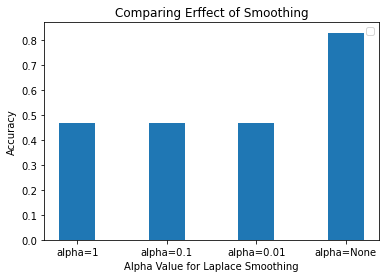

In [62]:
import numpy as np 
import matplotlib.pyplot as plt 
  
# Here 'alpha=None' is without smoothing
X = ['alpha=1','alpha=0.1','alpha=0.01', 'alpha=None']
accuracies = [0.46669778,0.4669, 0.46697,0.8290]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis,  accuracies, 0.4, label = None)
  
plt.xticks(X_axis, X)
plt.xlabel("Alpha Value for Laplace Smoothing")
plt.ylabel("Accuracy")
plt.title("Comparing Erffect of Smoothing")
plt.legend()
plt.show()